# Imports

In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker
import statistics

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf

#np.set_printoptions(threshold=np.inf)

# Connecto to Google Drive

Connecting to my own google drive to abe able to save a checkpoint for my models below.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
GOOGLE_DRIVE_PATH="/content/drive/MyDrive/machine_learning_models_reddit_sentiment"

Mounted at /content/drive


# Retriving the data

Here we are retriving the data from my repository located in the github so that we can have the .csv file with all the necessary data for our models

In [176]:
# Retrieving the data
!wget "https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/bitcoin_prediction%20(reddit%20posts)/final_data_reddit_bitcoin.csv"

--2023-06-04 20:57:21--  https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/bitcoin_prediction%20(reddit%20posts)/final_data_reddit_bitcoin.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 870950 (851K) [text/plain]
Saving to: ‘final_data_reddit_bitcoin.csv.1’

final_data_reddit_b 100%[===================>] 850.54K  --.-KB/s    in 0.02s   

2023-06-04 20:57:22 (47.9 MB/s) - ‘final_data_reddit_bitcoin.csv.1’ saved [870950/870950]



In [ ]:
# Load in the merged and final data
org_df = pd.read_csv('/content/final_data_reddit_bitcoin.csv',index_col=0)

In [ ]:
org_df

,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com,Open,High,Low,Close,Volume,Market Cap
date,,,,,,,,,,,,,
2010-07-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0858,0.0858,0.0858,0.0858,0.000000e+00,0.000000e+00
2010-07-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0808,0.0808,0.0808,0.0808,0.000000e+00,0.000000e+00
2010-07-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0747,0.0747,0.0747,0.0747,0.000000e+00,0.000000e+00
2010-07-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0792,0.0792,0.0792,0.0792,0.000000e+00,0.000000e+00
2010-07-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0505,0.0505,0.0505,0.0505,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26795.0300,27001.3400,26705.3500,26789.0600,4.064762e+10,5.193336e+11
2023-05-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26785.6000,27136.6500,26676.4700,26906.1700,2.963904e+10,5.202518e+11
2023-05-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26917.5900,27613.4000,26754.3200,27192.1700,3.734884e+10,5.293194e+11


In [ ]:
org_df.columns

Index(['reddit_flair', 'reddit_tb_polarity', 'reddit_tb_subjectivity',
       'reddit_sid_pos', 'reddit_sid_neg', 'reddit_sid_neu', 'reddit_sid_com',
       'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'],
      dtype='object')

# Creating the dataset

In thic chapter here we're going to create out datasets in order to have our data ready for our models

In [ ]:
dataset = org_df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
num_of_features = len(org_df.columns)
print('Number of features', num_of_features)

Number of features 13


## Creating the hyperparameters

We're creating here the parameters (some of them atleast) is that we need them in order to create our train and test data

In [ ]:
# Hyperparameters
LOOK_BACK = 30
EPOCHS = 1000
BATCH_SIZE = 128
HORIZON = 1

## Creating the test and train dataset

In [ ]:
train_size_percent = 0.80
pred_col = org_df.columns.get_loc('Close')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  print(len(dataset)-look_back-1)
  return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=LOOK_BACK)
testX, testY = create_dataset(test, pred_col, look_back=LOOK_BACK)

# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], LOOK_BACK, num_of_features))
testX = np.reshape(testX, (testX.shape[0],LOOK_BACK, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('LOOK_BACK ', LOOK_BACK)

3712
905
Training dataset length  3743
Testing dataset length  936
LOOK_BACK  30


In [ ]:
# Create a function to implement a ModelCheckoint callback with a specific filename
def create_model_checkpoint(model_name, save_path=GOOGLE_DRIVE_PATH):
  return tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(save_path, model_name),
      verbosity=0, # only output a limited amount of text
      save_best_only=True
  )

# Creating the models

In this chapter here we're going to create the models that we're going to test them against our data.

## Model 1: LSTM

In [ ]:
# LSTM Hyperparameters
LSTM_LAYERS = 128

# Create and fit the LSTM network
model_lstm = Sequential(name="bitcoin_prediction_reddit_sentiment_lstm")
model_lstm.add(LSTM(LSTM_LAYERS, input_shape=(LOOK_BACK, num_of_features)))
model_lstm.add(Dense(HORIZON, activation="linear", name="output_layer"))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
history_lstm = model_lstm.fit(
    trainX,
    trainY,
    validation_split=0.30,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            patience=100
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=200,
            restore_best_weights=True
        ),
        create_model_checkpoint(model_name=model_lstm.name)
    ]
)

In [ ]:
model_lstm = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/bitcoin_prediction_reddit_sentiment_lstm")

## Model 2: CNN

In [ ]:
# CNN Hyperparameters
CNN_LAYERS = 128
CNN_KERNEL_SIZE = 5

# Set random seed
tf.random.set_seed(42)

# Create Conv1D model
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=CNN_LAYERS, kernel_size=CNN_KERNEL_SIZE, padding="causal", activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear", name="output_layer")
], name="bitcoin_prediction_reddit_sentiment_conv1d")

# Compile the model
model_cnn.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
history_cnn = model_cnn.fit(
    trainX,
    trainY,
    validation_split = 0.30,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    shuffle = False,
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            patience=100
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=200,
            restore_best_weights=True
        ),
        create_model_checkpoint(model_name=model_cnn.name)
    ]
)

In [ ]:
model_cnn = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/bitcoin_prediction_reddit_sentiment_conv1d")

## Model 3: Ensemble Model

In [171]:
def get_ensemble_models(horizon = HORIZON,
                        trainX = trainX,
                        trainY = trainY,
                        num_iter = 10,
                        num_epochs = 1000,
                        ):
  """
  Returns a list of num_iter models each trained on MAE
  """
  # Make empty list for trained ensemble models
  ensemble_models = []
  history_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Construct a simple model (similar to model_1)
    model = tf.keras.Sequential([
        # Initialize dense layers with normal distribution for estimating prediction intervals
        tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        tf.keras.layers.Dense(HORIZON, activation="linear")
    ], name="bitcoin_prediction_reddit_sentiment_ensemble")

    # Compile simple model with current loss function
    model.compile(
        loss="mae",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["mae", "mse"]
    )

    # Fit the current model
    model.fit(
        trainX,
        trainY,
        epochs=num_epochs,
        verbose=0,
        validation_split = 0.30,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=200,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                patience=100,
                verbose=1
            )
        ]
    )

    # Append fitted model to list of ensemble models
    ensemble_models.append(model)
    history_models.append(model.history)

  return ensemble_models, history_models

In [172]:
# Get list of trained ensemble models
ensemble_models, history_ensemble = get_ensemble_models(num_iter=2,
                                      num_epochs=1000
                                      )


Epoch 160: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 260: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 110: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 210: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
[<keras.engine.sequential.Sequential object at 0x7f29d9a0a9b0>, <keras.engine.sequential.Sequential object at 0x7f29d853e050>]


# Plotting and predicting

In this chapter we're going to plot our results and display what our models learned and how well they managed to perform

## Usefull functions

It is to be noted that those only apply for LSTM and CNN only because the ensemble model is a little bit more complicated than that.
Having multiple models togheter requires extra code and touch to have it running

In [ ]:
def plot_model_training(history_model):
  # Plot training
  plt.plot(history_model.history['loss'])
  plt.plot(history_model.history['val_loss'])
  
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.show()

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred):
    diff = tf.abs(y_true - y_pred)
    scaled_diff = diff / tf.abs(y_true[1:] - y_true[:-1])
    return tf.reduce_mean(scaled_diff)

In [ ]:
def get_train_test_predict(model):
  
  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)

  if (len(trainPredict.shape)) > 2 or (len(testPredict.shape)) > 2:
    trainPredict = np.squeeze(trainPredict)
    testPredict = np.squeeze(testPredict)

  # Get something which has as many features as dataset
  trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
  # Put the predictions there
  trainPredict_extended[:,pred_col] = trainPredict[:,0]
  # Inverse transform it and select the 3rd column.
  trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

  # Get something which has as many features as dataset
  testPredict_extended = np.zeros((len(testPredict),num_of_features))
  # Put the predictions there
  testPredict_extended[:,pred_col] = testPredict[:,0]
  # Inverse transform it and select the pred_col column.
  testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

  return trainPredict, testPredict

In [156]:
def calculate_train_test_mae(model, trainY=trainY, testY=testY):  
  trainPredict, testPredict = get_train_test_predict(model)

  trainY_extended = np.zeros((len(trainY),num_of_features))
  trainY_extended[:,pred_col]=trainY
  trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

  testY_extended = np.zeros((len(testY),num_of_features))
  testY_extended[:,pred_col]=testY
  testY = scaler.inverse_transform(testY_extended)[:,pred_col]

  # calculate root mean squared error
  trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
  testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

  # calculate absolute mean error
  trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
  testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

  return trainScore_MAE, trainScore_RMSE, testScore_MAE, testScore_RMSE


In [ ]:
def plot_price_prediction(model):

  trainPredict, testPredict = get_train_test_predict(model)

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[LOOK_BACK:len(trainPredict)+LOOK_BACK, pred_col] = trainPredict

  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(LOOK_BACK*2)+1:len(dataset)-1, pred_col] = testPredict

  # contruct pandas dataframe for plotting
  time_df = pd.DataFrame(org_df.index)
  time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
  df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
  df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
  time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
  time_df2.set_index('date',inplace=True)

  # plot the output
  fig, ax = plt.subplots(figsize=(15,7))
  time_df2.plot(ax=ax,rot=90,alpha=0.7)
  plt.xlabel('Timestamp')
  plt.ylabel('Bitcoin Value')
  plt.title('Bitcoin Price Prediction')
  plt.savefig(model.name + '.png',bbox_inches = "tight")

In [ ]:
def print_results(model):
  print('-' * 50)
  print('Experiment name:', model.name)

  print('-' * 50)
  print('look_back days:', LOOK_BACK/24)
  # print('lstm_layers:', lstm_layers)
  print('epochs:', EPOCHS)
  print('batch_size:', BATCH_SIZE)
  print('dataset features', list(org_df.columns))

  trainScore_MAE, trainScore_RMSE, testScore_MAE, testScore_RMSE = calculate_train_test_mae(model)

  print('-' * 50)
  print('Train Score: %.2f RMSE' % (trainScore_RMSE))
  print('Test Score: %.2f RMSE' % (testScore_RMSE))

  print('-' * 50)
  print('Train Score: %.2f MAE' % (trainScore_MAE))
  print('Test Score: %.2f MAE' % (testScore_MAE))

  print('-' * 50)
  print('Model summary:')
  model.summary()

## Usefull functions for the Ensemble Model

In [ ]:
def plot_model_training_ensemble(history_models):
  loss = []
  val_loss = []
  for history_model in history_models:
    loss.append(history_model.history['loss'])
    val_loss.append(history_model.history['val_loss'])

  loss = [sum(values) / len(values) for values in zip(*loss)]
  val_loss = [sum(values) / len(values) for values in zip(*val_loss)]

  # Plot training
  plt.plot(loss)
  plt.plot(val_loss)

  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.show()

In [ ]:
def get_train_test_predict_ensemble(model):

  # Make sure float32 (for metric calculations)
  trainXCast = tf.cast(trainX, dtype=tf.float64)
  testXCast = tf.cast(testX, dtype=tf.float64)
  
  trainPredict = model.predict(trainXCast)
  testPredict = model.predict(testXCast)

  # Get something which has as many features as dataset
  trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
  # Put the predictions there
  trainPredict_extended[:,pred_col] = tf.squeeze(trainPredict[:,0])
  # Inverse transform it and select the 3rd column.
  trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

  # Get something which has as many features as dataset
  testPredict_extended = np.zeros((len(testPredict),num_of_features))
  # Put the predictions there
  testPredict_extended[:,pred_col] = tf.squeeze(testPredict[:,0])
  # Inverse transform it and select the pred_col column.
  testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

  return trainPredict, testPredict

In [169]:
def calculate_train_test_mae_ensemble(models, trainY=trainY, testY=testY):

  trainRMSE = []
  testRMSE = []
  trainMAE = []
  testMAE = []

  for i in range(0, len(models)):
    model = models[i]
    trainPredict, testPredict = get_train_test_predict_ensemble(model)

    trainY_extended = np.zeros((len(trainY),num_of_features))
    trainY_extended[:,pred_col]=trainY
    trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

    testY_extended = np.zeros((len(testY),num_of_features))
    testY_extended[:,pred_col]=testY
    testY = scaler.inverse_transform(testY_extended)[:,pred_col]

    # calculate root mean squared error
    trainScore_RMSE = np.sqrt(mean_squared_error(trainY, trainPredict))
    testScore_RMSE = np.sqrt(mean_squared_error(testY, testPredict))

    # calculate absolute mean error
    trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
    testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

    trainRMSE.append(trainScore_RMSE)
    testRMSE.append(testScore_RMSE)
    trainMAE.append(trainScore_MAE)
    testMAE.append(testScore_MAE)

  
  print(len(trainMAE))
  return tf.reduce_mean(trainMAE, axis=0), tf.reduce_mean(trainRMSE, axis=0), tf.reduce_mean(testMAE, axis=0), tf.reduce_mean(testRMSE, axis=0)

In [ ]:
def plot_price_prediction_ensemble(models):

  trainPredictList = []
  testPredictList = []
  for i in range(0, len(models)):
    model = models[i]
    train, test = get_train_test_predict_ensemble(model)
    trainPredictList.append(train)
    testPredictList.append(test)
  
  trainPredict = [0] * len(trainPredictList[0])
  for i in range(0, len(trainPredictList)):
    predList = trainPredictList[i]
    for j in range(0, len(predList)):
      trainPredict[j] += predList[j]

  for i in range(0, len(trainPredict)):
    trainPredict[i] /= len(trainPredictList)

  testPredict = [0] * len(testPredictList[0])
  for i in range(0, len(testPredictList)):
    predList = testPredictList[i]
    for j in range(0, len(predList)):
      testPredict[j] += predList[j]

  for i in range(0, len(testPredict)):
    testPredict[i] /= len(testPredictList)

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[LOOK_BACK:len(trainPredict)+LOOK_BACK, pred_col] = trainPredict

  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(LOOK_BACK*2)+1:len(dataset)-1, pred_col] = testPredict

  # contruct pandas dataframe for plotting
  time_df = pd.DataFrame(org_df.index)
  time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
  df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
  df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
  time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
  time_df2.set_index('date',inplace=True)

  # plot the output
  fig, ax = plt.subplots(figsize=(15,7))
  time_df2.plot(ax=ax,rot=90,alpha=0.7)
  plt.xlabel('Timestamp')
  plt.ylabel('Bitcoin Value')
  plt.title('Bitcoin Price Prediction')
  plt.savefig(model.name + '.png',bbox_inches = "tight")

In [160]:
def print_results_ensemble(models):
  print('-' * 50)
  print('Experiment name:', models[0].name)

  print('-' * 50)
  print('look_back days:', LOOK_BACK/24)
  # print('lstm_layers:', lstm_layers)
  print('epochs:', EPOCHS)
  print('batch_size:', BATCH_SIZE)
  print('dataset features', list(org_df.columns))

  trainScore_MAE, trainScore_RMSE, testScore_MAE, testScore_RMSE = calculate_train_test_mae_ensemble(models)

  print('-' * 50)
  print('Train Score: %.2f RMSE' % (trainScore_RMSE))
  print('Test Score: %.2f RMSE' % (testScore_RMSE))

  print('-' * 50)
  print('Train Score: %.2f MAE' % (trainScore_MAE))
  print('Test Score: %.2f MAE' % (testScore_MAE))

  print('-' * 50)
  print('Model summary:')
  model_lstm.summary()

# Displaying the models results

## LSTM

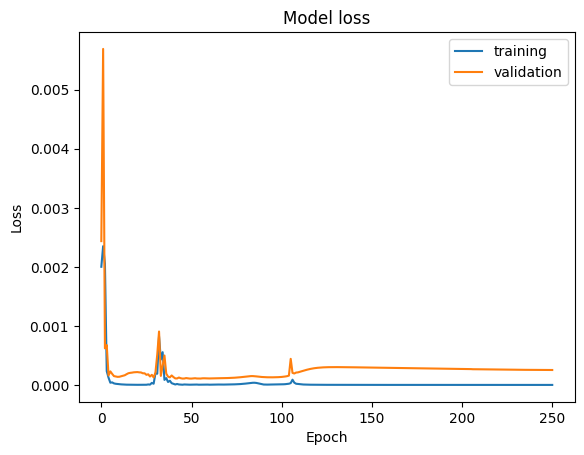

In [ ]:
plot_model_training(history_lstm)

29/29 [==============================] - 0s 10ms/step
3712 905
--------------------------------------------------
Experiment name: bitcoin_prediction_reddit_sentiment_lstm
--------------------------------------------------
look_back days: 1.25
epochs: 1000
batch_size: 128
dataset features ['reddit_flair', 'reddit_tb_polarity', 'reddit_tb_subjectivity', 'reddit_sid_pos', 'reddit_sid_neg', 'reddit_sid_neu', 'reddit_sid_com', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
29/29 [==============================] - 0s 12ms/step
--------------------------------------------------
Train Score: 423.66 RMSE
Test Score: 2362.12 RMSE
--------------------------------------------------
Train Score: 270.06 MAE
Test Score: 1804.91 MAE
--------------------------------------------------
Model summary:
Model: "bitcoin_prediction_reddit_sentiment_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)   

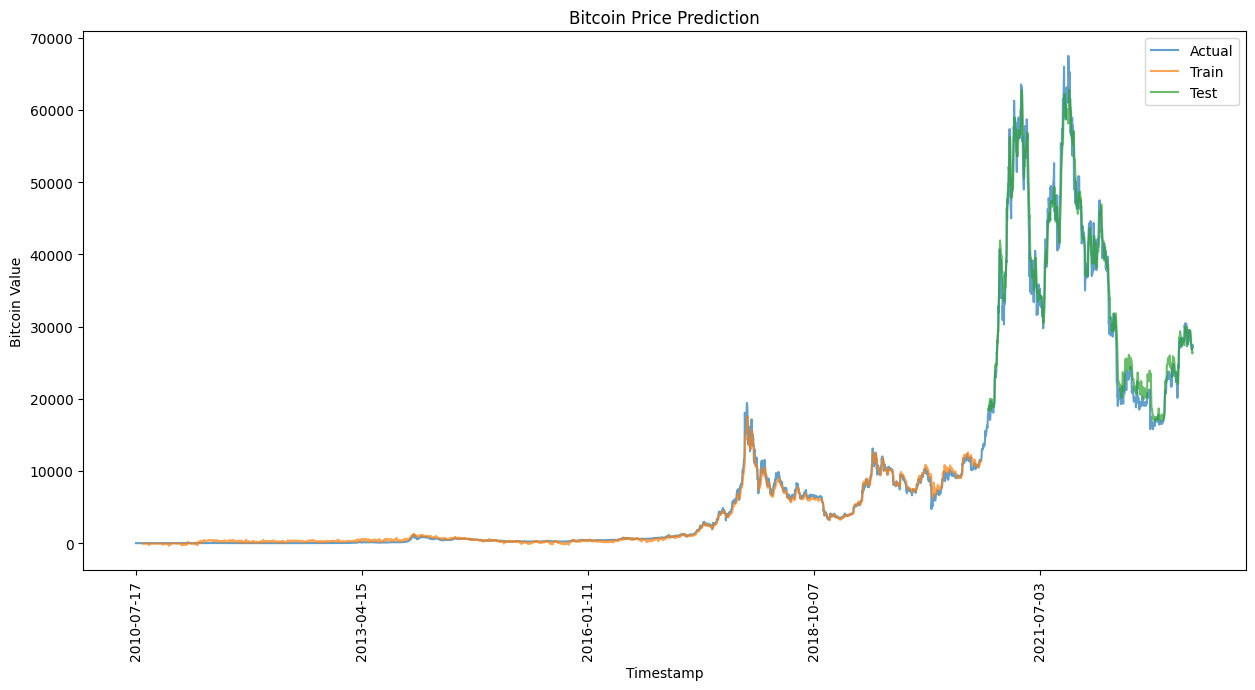

In [ ]:
plot_price_prediction(model_lstm)
print_results(model_lstm)

## CNN

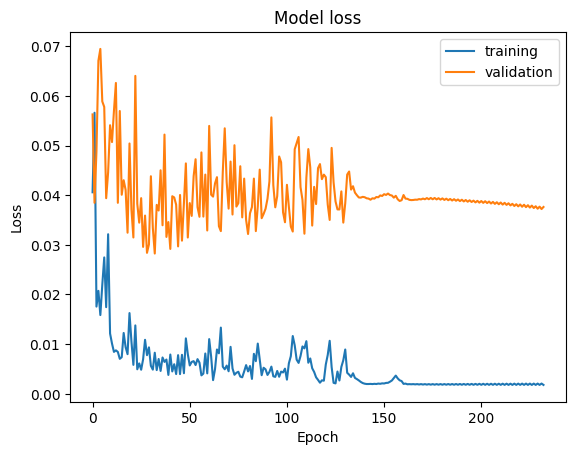

In [ ]:
plot_model_training(history_cnn)

29/29 [==============================] - 0s 2ms/step
3712 905
--------------------------------------------------
Experiment name: bitcoin_prediction_reddit_sentiment_conv1d
--------------------------------------------------
look_back days: 1.25
epochs: 1000
batch_size: 128
dataset features ['reddit_flair', 'reddit_tb_polarity', 'reddit_tb_subjectivity', 'reddit_sid_pos', 'reddit_sid_neg', 'reddit_sid_neu', 'reddit_sid_com', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
29/29 [==============================] - 0s 2ms/step
--------------------------------------------------
Train Score: 1284.57 RMSE
Test Score: 7929.56 RMSE
--------------------------------------------------
Train Score: 726.45 MAE
Test Score: 5972.46 MAE
--------------------------------------------------
Model summary:
Model: "bitcoin_prediction_reddit_sentiment_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)  

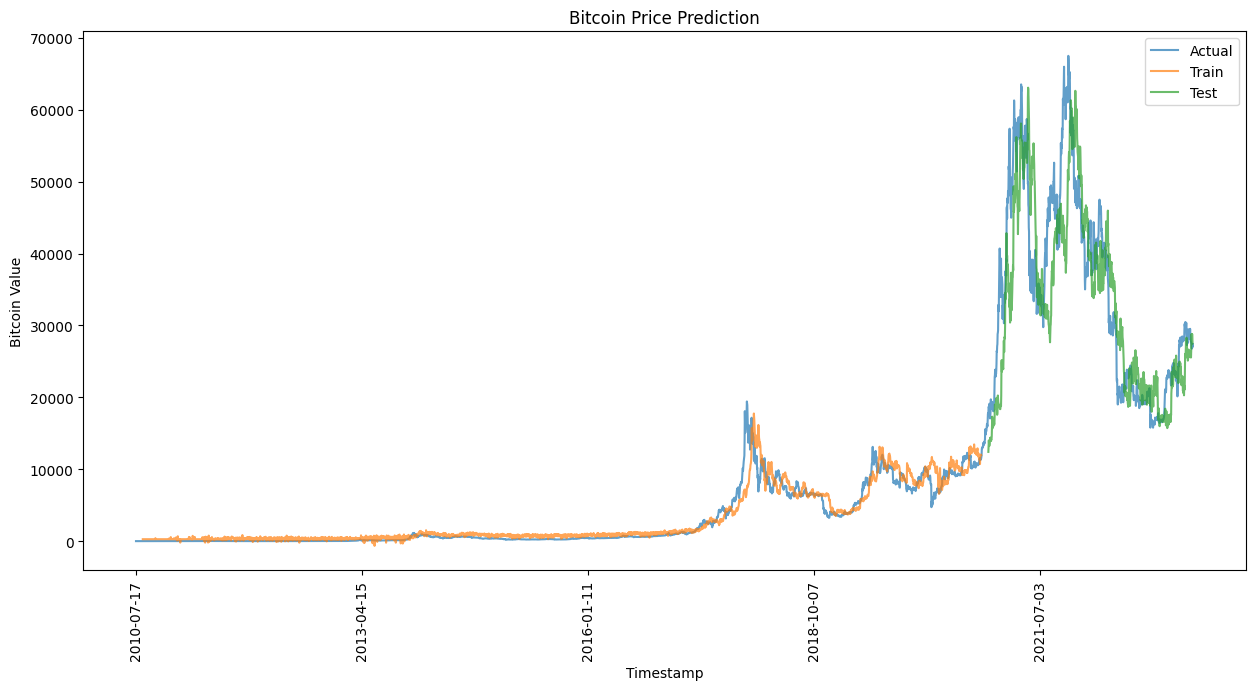

In [ ]:
plot_price_prediction(model_cnn)
print_results(model_cnn)

## Ensemble Model

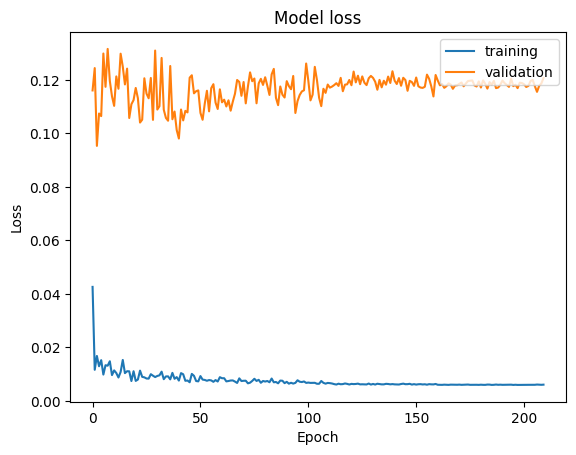

In [174]:
plot_model_training_ensemble(history_ensemble)

29/29 [==============================] - 0s 4ms/step
--------------------------------------------------
Experiment name: bitcoin_prediction_reddit_sentiment_ensemble
--------------------------------------------------
look_back days: 1.25
epochs: 1000
batch_size: 128
dataset features ['reddit_flair', 'reddit_tb_polarity', 'reddit_tb_subjectivity', 'reddit_sid_pos', 'reddit_sid_neg', 'reddit_sid_neu', 'reddit_sid_com', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
29/29 [==============================] - 0s 3ms/step
2
--------------------------------------------------
Train Score: 160095981.54 RMSE
Test Score: 1269410126.51 RMSE
--------------------------------------------------
Train Score: 92783346.21 MAE
Test Score: 1182236321.75 MAE
--------------------------------------------------
Model summary:
Model: "bitcoin_prediction_reddit_sentiment_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param # 

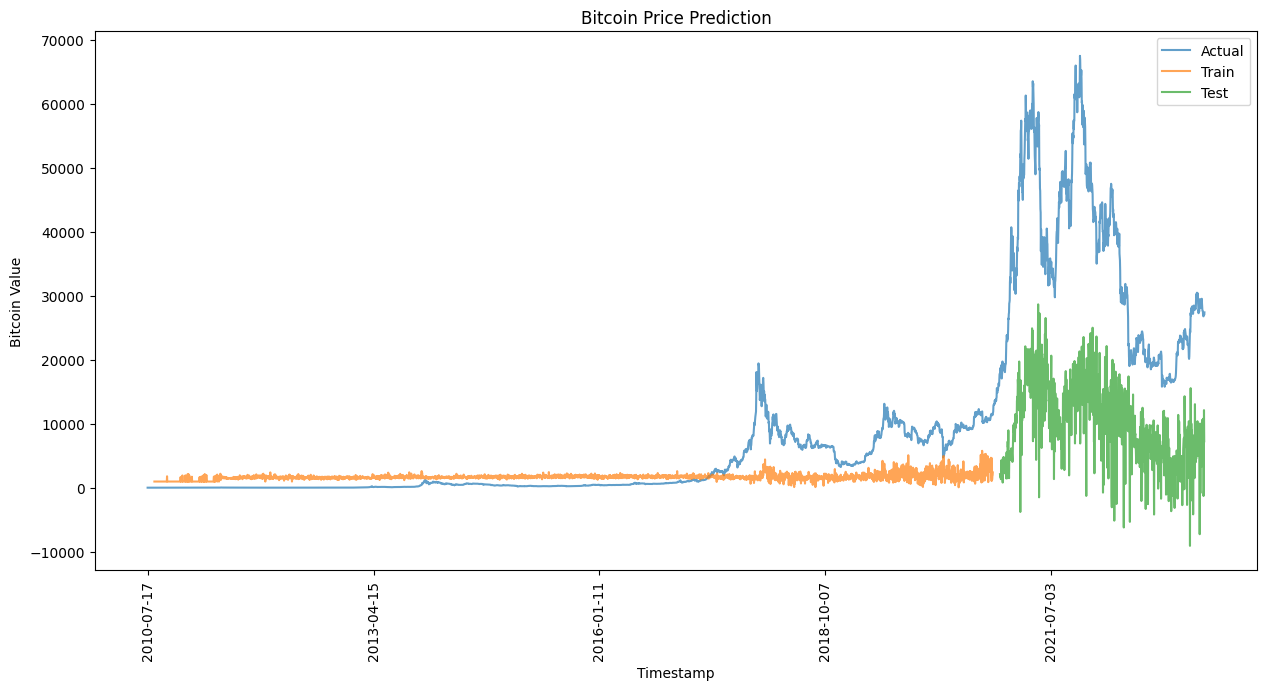

In [173]:
plot_price_prediction_ensemble(ensemble_models)
print_results_ensemble(ensemble_models)